## TOC:
* [Setup](#first-bullet)
* [Image Registration](#second-bullet)
* [Morphological Operations](#third-bullet)
* [Edge Detection](#fourth-bullet)
* [Corner Detection](#fifth-bullet)
* [TLDR](#last-bullet)


## Setup <a class="anchor" id="first-bullet"></a>

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def read_img_rgb(img_name):
    img_rgb = cv2.cvtColor(cv2.imread(f'../L1/{img_name}'), cv2.COLOR_BGR2RGB)
    return img_rgb

def read_img_grayscale(img_name):
    img_g = cv2.cvtColor(cv2.imread(f'../L1/{img_name}'), cv2.COLOR_BGR2GRAY)
    return img_g

## Image Registration <a class="anchor" id="second-bullet"></a>

## Image registration is the process of aligning two or more images of the same scene taken at different times, from different viewpoints, or by different sensors.

## Use-cases:
- Aligning satellite images taken at different times to monitor environmental changes.
- Registering medical images from different modalities (e.g., CT and MRI scans) for diagnosis.
- Aligning frames in a video sequence to stabilize the output.

## Algorithmic steps:
* Feature detection (e.g., corners, edges) and descriptors (eg: description of area around corner/edge, SIFT, ORB).
    * In image registration, features such as points, edges, or regions are detected and used for alignment.
    * Detect key points in both images.
    * Popular Feature Detectors: SIFT (non-free), SURF (no-free, ip protected), ORB
* Feature matching (e.g. matching descriptors [of the detected features], nearest-neighbor, RANSAC).
    * After detecting key points and computing descriptors, the next step is to find correspondences between the images
    * Methods:  
        * Brute Force Matching
            * compares each descriptor from the first image with every descriptor from the second image and finds the best match based on a distance metric
            * The distance measures how similar the two descriptors are. In ORB (with BRIEF descriptors), the Hamming distance is often used \
            because BRIEF descriptors are binary (made up of 0s and 1s).
Hamming distance counts how many bits differ between two binary vectors. Lower distance = better match.
        * FLANN
            * Uses approximate nearest-neighbor algorithms. It uses clever data structures (like KD-trees) to approximate the nearest neighbors
* Transformation model estimation (e.g., affine, homography).
    * The next step is to compute a transformation that aligns the two sets of matched points. Homography.
* Image transformation (warping the images to align them).
    * The second image is transformed/warped to align with the reference image

https://stackoverflow.com/questions/31835114/feature-detection-with-patent-free-descriptors

**ORB** (Oriented FAST and Rotated BRIEF)
* ORB combines two algorithms: FAST (Features from Accelerated Segment Test) for keypoint detection and BRIEF (Binary Robust Independent Elementary Features) for descriptor extraction. It adds improvements like orientation assignment and rotation-invariance.

ORB Steps Breakdown:
* Keypoint Detection using FAST:
    * ORB uses the FAST algorithm to detect keypoints in the image.
    * Keypoints are interesting points in the image that are distinct and can be reliably detected in different images (e.g., corners, blobs).
    * FAST works by comparing the intensity of a candidate pixel to surrounding pixels in a circle (typically 16 pixels). If enough of these pixels are brighter or darker than the candidate, it's marked as a keypoint.
* Orientation Assignment:
    * ORB adds an orientation step to FAST to make it rotation-invariant. This means even if the image is rotated, the keypoints can still be detected consistently.
    * It computes the intensity centroid around each keypoint. The direction from the keypoint to this centroid is the assigned orientation.
* Feature Description using BRIEF:
    * For each detected keypoint, ORB extracts a descriptor using the BRIEF algorithm.
    * A descriptor is a compact binary string (vector) that represents the appearance of the region around the keypoint.
    * BRIEF uses a series of binary tests (intensity comparisons between pairs of pixels) around the keypoint, generating a unique string of 0s and 1s.
* Rotation-Invariant BRIEF:
    * ORB modifies BRIEF by rotating the feature descriptors according to the orientation of the keypoint to maintain rotation invariance.

Output:
* Keypoints: Points of interest in the image, often detected at edges or corners.
* Descriptors: Compact binary vectors (128 or 256 bits long) that describe the appearance of the region around each keypoint. These descriptors are used for matching keypoints between images.

**SIFT** (Scale-Invariant Feature Transform)
SIFT is another popular feature detection algorithm, and its key strength is scale-invariance—it can detect features reliably at different scales or zoom levels. Here are the steps:

Scale-Space Extrema Detection:

* SIFT builds a scale space by progressively blurring the image using Gaussian filters. It then subtracts blurred images from each other to create a Difference of Gaussians (DoG) image.
* Keypoints are detected as extrema (local maxima or minima) in this DoG image at different scales. This makes SIFT scale-invariant.

Keypoint Localization:
* For each keypoint, SIFT refines its location by rejecting low-contrast points and points along edges. This ensures the keypoints are robust and stable.

Orientation Assignment:
* SIFT computes a gradient orientation for each keypoint to achieve rotation invariance. The orientation is assigned based on the dominant gradient direction around the keypoint.

Keypoint Descriptor Creation:
* For each keypoint, SIFT generates a 128-dimensional vector that represents the local gradient information around the keypoint. This descriptor is scale- and rotation-invariant.

Output:
* Keypoints: Locations in the image that are scale- and rotation-invariant.
* Descriptors: 128-dimensional vectors that describe the gradient information around each keypoint.

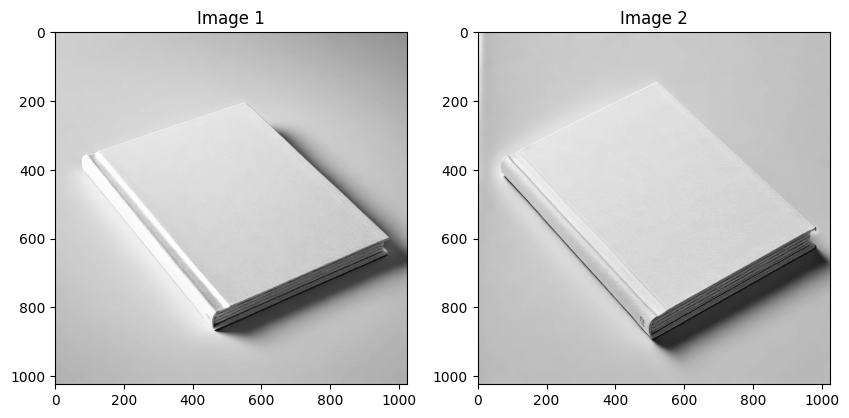

In [7]:
img1 = read_img_grayscale('../L4/obj1.jpg')
img2 = read_img_grayscale('../L4/obj2.jpg')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Image 1')
plt.imshow(img1, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Image 2')
plt.imshow(img2, cmap='gray')

plt.show()

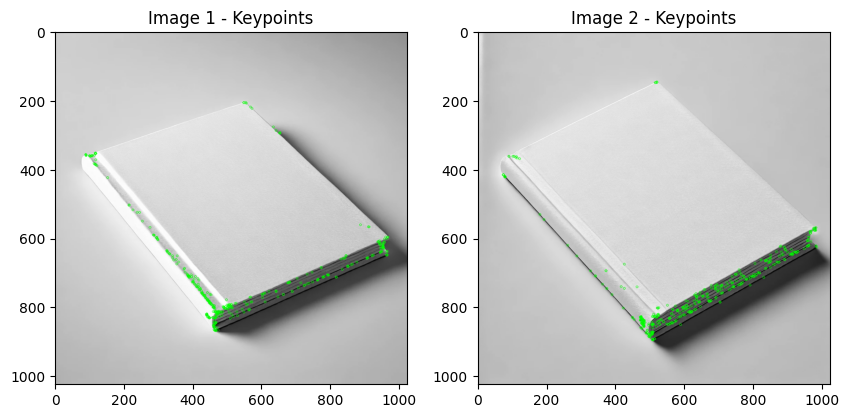

In [8]:
orb = cv2.ORB_create()

# Detect keypoints and descriptors
keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

# Draw keypoints on images
img1_kp = cv2.drawKeypoints(img1, keypoints1, None, color=(0,255,0), flags=0)
img2_kp = cv2.drawKeypoints(img2, keypoints2, None, color=(0,255,0), flags=0)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Image 1 - Keypoints')
plt.imshow(img1_kp, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Image 2 - Keypoints')
plt.imshow(img2_kp, cmap='gray')

plt.show()

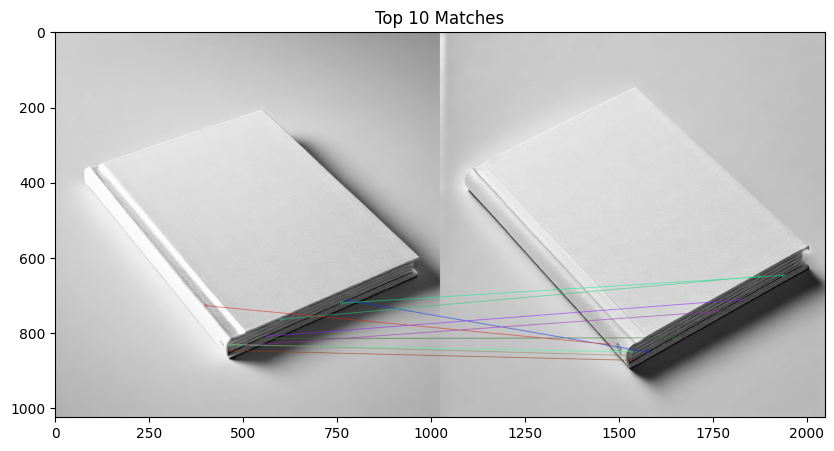

In [36]:
# Initialize BFMatcher with Hamming distance (used for ORB)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(descriptors1, descriptors2)

# Sort matches by distance
matches = sorted(matches, key=lambda x: x.distance)

# Empirical remove bad matches
matches = matches[10:]

# Draw top matches
img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Matches
plt.figure(figsize=(15, 5))
plt.title('Top 10 Matches')
plt.imshow(img_matches)
plt.show()

In [37]:
# Extract location of good matches
points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
points2 = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# Estimate homography matrix
H, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

# Homography matrix
print("Estimated Homography Matrix:")
print(H)

Estimated Homography Matrix:
[[ 5.03305739e+00  8.16383413e-01 -1.39497873e+03]
 [ 1.37886489e+00  3.64106975e+00 -7.45458086e+02]
 [ 2.23618129e-03  1.88977969e-03  1.00000000e+00]]


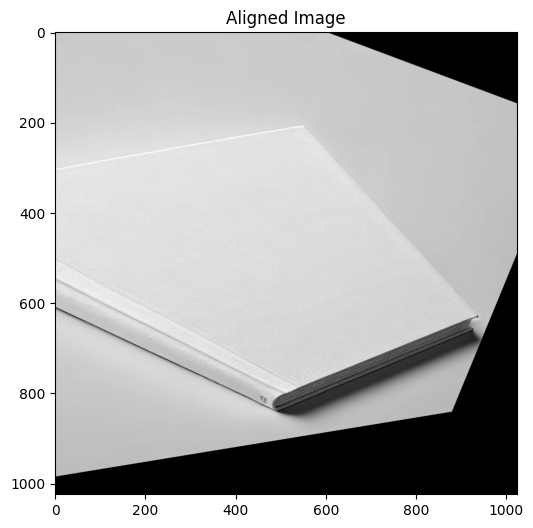

In [38]:
# Warp img2 to align with img1
height, width = img1.shape
aligned_img = cv2.warpPerspective(img2, H, (width, height))

# Display the aligned image
plt.figure(figsize=(6, 6))
plt.title('Aligned Image')
plt.imshow(aligned_img, cmap='gray')
plt.show()

https://medium.com/@hhroberthdaniel/how-to-speed-up-image-registration-with-opencv-by-100x-70c9cf786b81

## Morphological Operations <a class="anchor" id="third-bullet"></a>

## Morphological operations process images based on their shapes. They apply a structuring element to an input image, creating an output image of the same size.

## Use-cases:
 Noise removal, image enhancement, object extraction, and skeletonization.

## Key Operations:
* Erosion: Shrinks the object in the image.
    * Use-case: Removing small white noise or separating objects that are close together.
* Dilation: Expands the object in the image.
    * Use-case: Filling small holes or gaps in an object, and connecting nearby objects.
* Opening: Erosion followed by dilation.
    * Removing noise (e.g., salt and pepper noise) from binary images while keeping the larger objects intact.
* Closing: Dilation followed by erosion.
    * Filling small holes or gaps within the objects while preserving the boundaries.

Kernel Size: A larger kernel results in a stronger effect. A smaller kernel results in a weaker effect. \
Kernel Shape: Depending on the shape, the results may differ (rectangular, elliptical, cross-shaped). \
Iterations: Increasing the number of iterations will make the erosion or dilation stronger.

In [55]:
img3 = read_img_grayscale('../L1/geometric_shapes_2.webp')

### Erosion

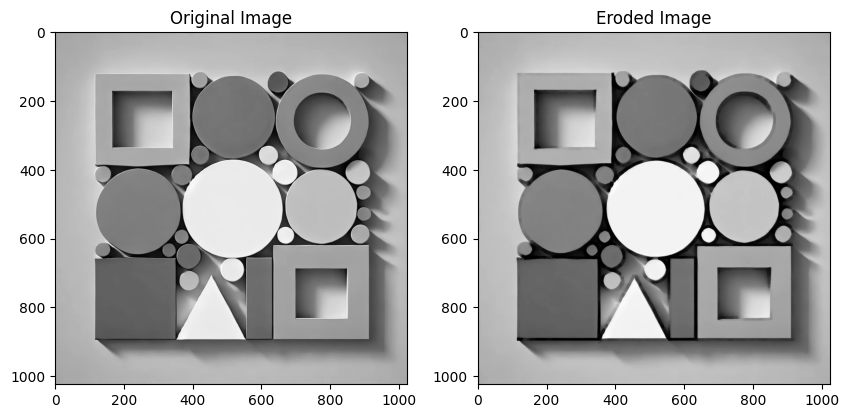

In [61]:
# Define structuring element
kernel = np.ones((5,5), np.uint8)


kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))

# Apply erosion
erosion = cv2.erode(img3, kernel, iterations=1)

# Display the original and eroded images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img3, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Eroded Image')
plt.imshow(erosion, cmap='gray')

plt.show()


### Dilation

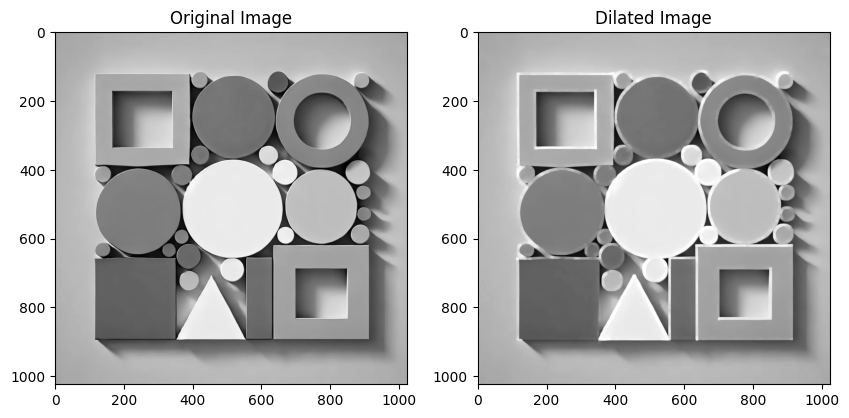

In [62]:
dilation = cv2.dilate(img3, kernel, iterations=1)

# Display the original and dilated images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img3, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Dilated Image')
plt.imshow(dilation, cmap='gray')

plt.show()

### Opening

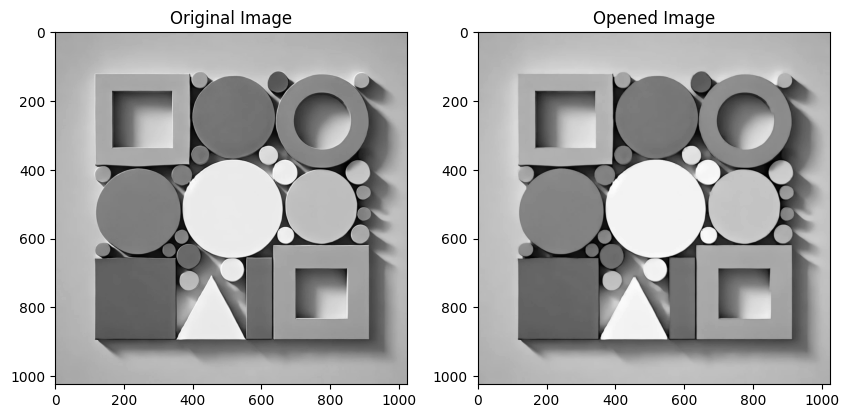

In [63]:
opening = cv2.morphologyEx(img3, cv2.MORPH_OPEN, kernel)

# Display the original and opened images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img3, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Opened Image')
plt.imshow(opening, cmap='gray')

plt.show()

### Closing

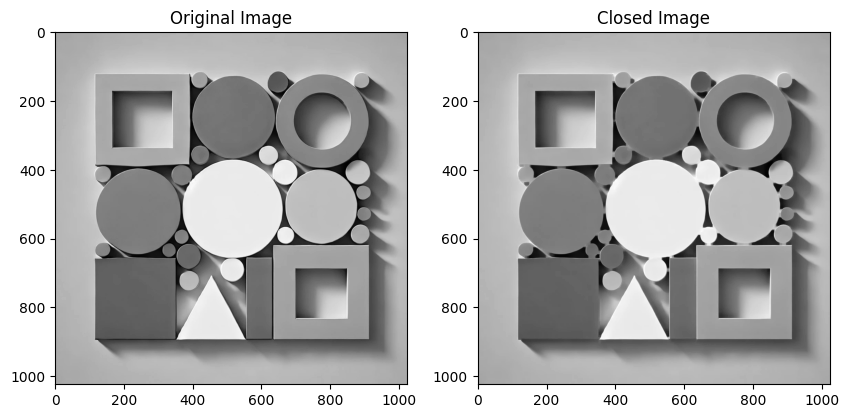

In [64]:
# Apply closing (dilation followed by erosion)
closing = cv2.morphologyEx(img3, cv2.MORPH_CLOSE, kernel)

# Display the original and closed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img3, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Closed Image')
plt.imshow(closing, cmap='gray')

plt.show()

## Edge Detection <a class="anchor" id="fourth-bullet"></a>

## Edge detection identifies points in an image where the brightness changes sharply.

## Use-cases: Object detection, image segmentation, and boundary detection.

## Algorithms:
- Sobel Filter: Detects edges using the gradient magnitude in x and y directions.
- Canny Edge Detection: A multi-stage algorithm for detecting edges with noise reduction and edge tracing.
- Marr-Hildreth (Laplacian of Gaussian): Detects edges by finding zero-crossings after smoothing the image.

### Sobel Operator (Edge Detection in Two Directions, X and Y)

- **Concept:** The Sobel operator computes the gradient of the image intensity at each pixel, emphasizing regions with high spatial frequency that correspond to edges. It uses two kernels to calculate derivatives in the x-direction and y-direction.
- **Use-case:** Sobel is often used for detecting edges with strong gradients. It is effective for highlighting horizontal and vertical edges separately.

**Mathematical Formula:**  
The Sobel operator uses two 3x3 kernels to approximate derivatives:
- Sobel in the **x-direction**:
$$
S_x = \begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix}
$$
- Sobel in the **y-direction**:
$$
S_y = \begin{bmatrix}
-1 & -2 & -1 \\
0 & 0 & 0 \\
1 & 2 & 1
\end{bmatrix}
$$

In [65]:
# Apply Sobel operator in X direction
sobel_x = cv2.Sobel(img3, cv2.CV_64F, 1, 0, ksize=3)

# Apply Sobel operator in Y direction
sobel_y = cv2.Sobel(img3, cv2.CV_64F, 0, 1, ksize=3)

In [66]:
# Convert results to uint8 for visualization
sobel_x = cv2.convertScaleAbs(sobel_x)
sobel_y = cv2.convertScaleAbs(sobel_y)

In [67]:
# Combine both X and Y direction results
sobel_combined = cv2.addWeighted(sobel_x, 0.5, sobel_y, 0.5, 0)

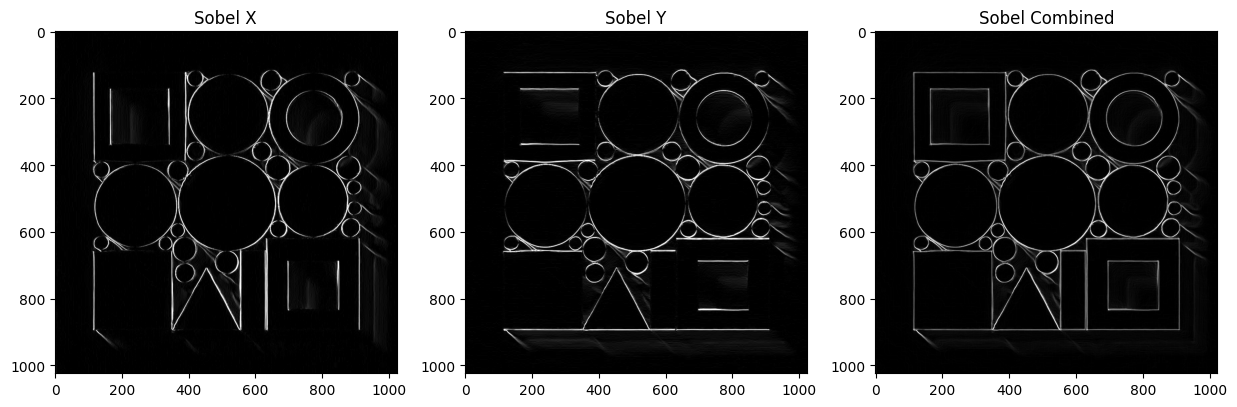

In [68]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Sobel X')
plt.imshow(sobel_x, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Sobel Y')
plt.imshow(sobel_y, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Sobel Combined')
plt.imshow(sobel_combined, cmap='gray')

plt.show()

### Canny edge detection 
It is a multi-stage algorithm that detects edges by filtering out noise, finding intensity gradients, \
applying non-maximum suppression, and performing edge tracking using hysteresis. It is one of the most widely used edge detection methods. \

Use-case: Canny is used when robust, noise-resistant edge detection is needed. \
It produces clear, thin edges and works well in noisy images.

* Intensity Gradients
    * It measure the rate of change in pixel intensity across the image. They indicate how "quickly" the brightness of the image is changing at each point. At an edge, the intensity changes abruptly (e.g., from black to white), so the gradient is high.
    * In Canny these gradients are used to calculate the gradient magnitude (strength of the edge at that point) and gradient direction ( of the edge) at each pixel.
        * Magnitude $ G = \sqrt{G_x^2 + G_y^2} $
        * Direction $ \theta = \tan^{-1} \left( \frac{G_y}{G_x} \right) $

* Non-maximum suppression
    * It is used to thin the edges by preserving only the local maxima in the gradient magnitude image. Essentially, it ensures that only the sharpest, most prominent edges are kept, while weaker and redundant edges are removed.
    * How it works:
        * For each pixel, Canny looks at its gradient direction (the direction in which the intensity is changing the most).
        * It then checks the pixels before and after it along that gradient direction.
        * If the current pixel is not greater than its neighbors in that direction, it is suppressed (set to zero).

* Hysteresis Thresholding
    * After non-maximum suppression, there may still be some weak edges that need to be refined. Hysteresis thresholding is used to classify edges as either strong, weak, or non-edges based on two thresholds:
        * High Threshold: Pixels with a gradient magnitude higher than this threshold are considered strong edges.
        * Low Threshold: Pixels with a gradient magnitude below this threshold are considered non-edges.
        * Between Thresholds: Pixels that fall between the two thresholds are considered weak edges.
    * How it works:
        * Strong edges are kept.
        * Weak edges are kept only if they are connected to strong edges (this step is called edge tracking). This ensures that only meaningful weak edges are retained, while isolated ones (often caused by noise) are discarded.

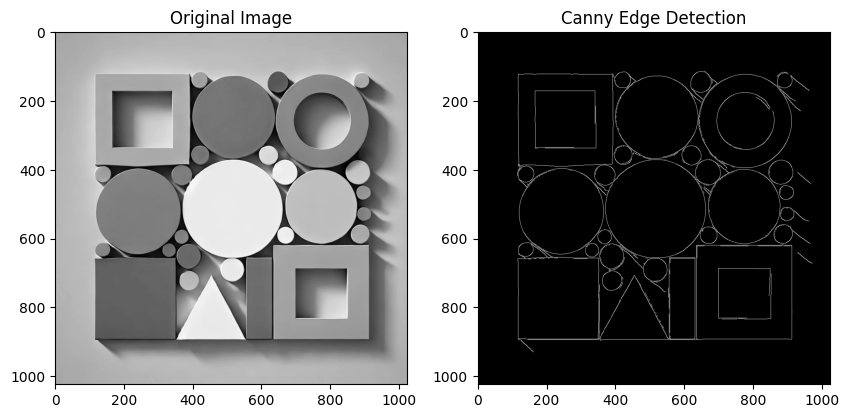

In [70]:
# Apply Canny edge detection
edges = cv2.Canny(img3, 100, 200)

# Display the original and edge-detected images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img3, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Canny Edge Detection')
plt.imshow(edges, cmap='gray')

plt.show()

In [73]:
# Step 1: Smooth the image using Gaussian blur to reduce noise (like Canny)
blurred_img = cv2.GaussianBlur(img3, (5, 5), 1.4)

# Step 2: Compute Sobel gradients in x and y directions
sobel_x = cv2.Sobel(blurred_img, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(blurred_img, cv2.CV_64F, 0, 1, ksize=3)

# Step 3: Compute Gradient Magnitude and Direction
gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
gradient_direction = np.arctan2(sobel_y, sobel_x) * (180 / np.pi)  # Convert radians to degrees

# Normalize gradient magnitude for visualization
gradient_magnitude_normalized = cv2.convertScaleAbs(gradient_magnitude)

# Step 4: Perform Canny edge detection up to different stages
# Canny edge detection up to non-maximum suppression (high and low threshold are chosen)
canny_before_nms = cv2.Canny(img3, 100, 200, L2gradient=True, apertureSize=3)

# Final Canny edge detection (this includes all steps, including non-maximum suppression and hysteresis)
canny_final = cv2.Canny(img3, 100, 200)

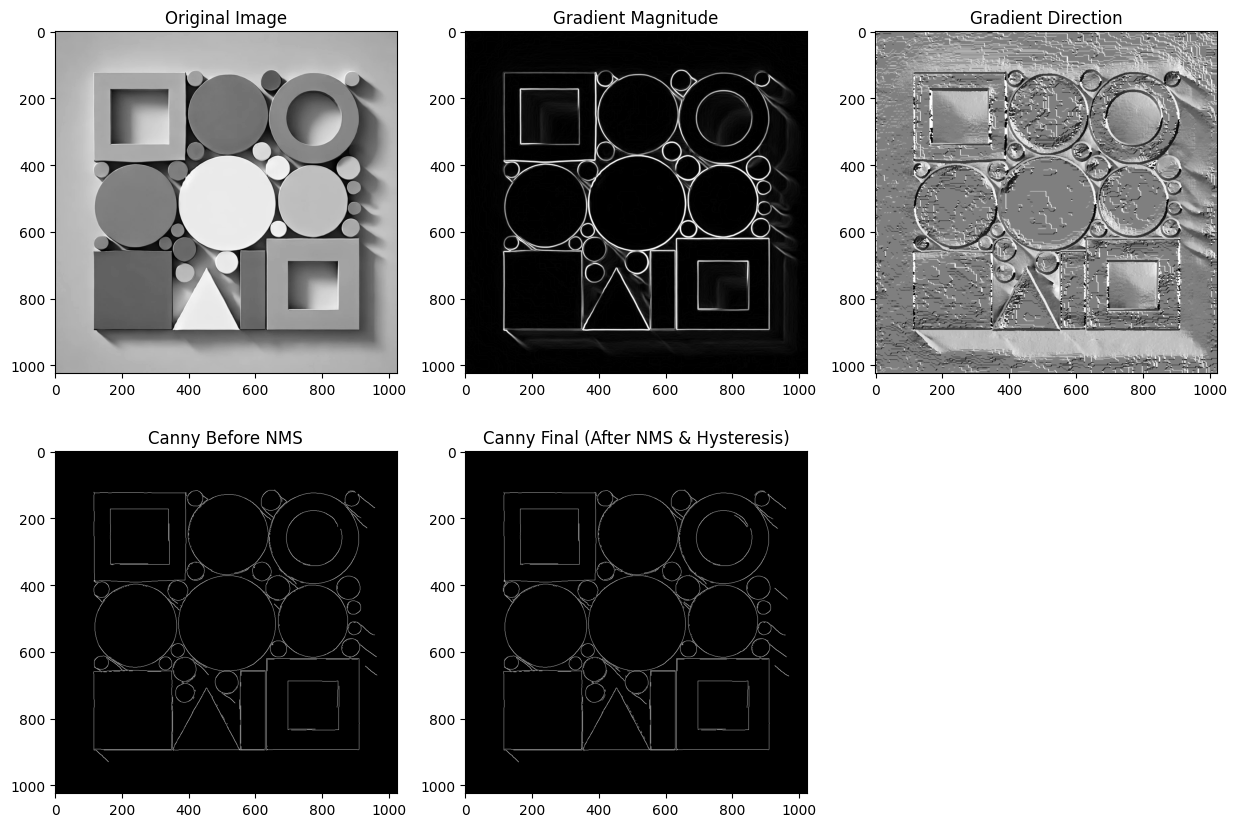

In [74]:
plt.figure(figsize=(15, 10))

# Original Image
plt.subplot(2, 3, 1)
plt.title('Original Image')
plt.imshow(img3, cmap='gray')

# Gradient Magnitude Image
plt.subplot(2, 3, 2)
plt.title('Gradient Magnitude')
plt.imshow(gradient_magnitude_normalized, cmap='gray')

# Gradient Direction (Visualizing just for understanding, not typically visualized directly in the process)
plt.subplot(2, 3, 3)
plt.title('Gradient Direction')
plt.imshow(gradient_direction, cmap='gray')

# Canny Edge Detection Before Non-Maximum Suppression (using magnitude)
plt.subplot(2, 3, 4)
plt.title('Canny Before NMS')
plt.imshow(canny_before_nms, cmap='gray')

# Canny After Non-Maximum Suppression and Hysteresis (Final Canny)
plt.subplot(2, 3, 5)
plt.title('Canny Final (After NMS & Hysteresis)')
plt.imshow(canny_final, cmap='gray')

plt.show()

### The Marr-Hildreth

The algorithm uses the Laplacian of Gaussian (LoG) for edge detection. \
First, it smooths the image with a Gaussian filter, then applies the Laplacian operator to detect zero-crossings, which indicate the edges.

Use-case: The Marr-Hildreth method is used when detecting edges with multiple directions, especially for detecting curves or circular shapes.

* Laplacian Operator
    * The Laplacian operator is a second derivative operator used in edge detection. While first derivatives (like Sobel or Prewitt) detect edges by looking for points of maximum gradient (changes in intensity), the Laplacian detects edges by finding zero-crossings in the second derivative. In simpler terms, it looks for points where the rate of change in intensity changes direction (i.e., going from increasing to decreasing).
    * Mathematical formula: $ \nabla^2 f = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2} $
        * Where f is the image function, and the Laplacian is the sum of the second partial derivatives in the x and y directions. 
        * It highlights regions of rapid intensity change, such as edges, but is sensitive to noise.

* Gaussian smoothing, also known as Gaussian blurring
    * Is a technique used in image processing to reduce noise and detail in an image by applying a Gaussian filter.
    * $ G(x, y) = \frac{1}{2\pi\sigma^2} e^{-\frac{x^2 + y^2}{2\sigma^2}} $

* Laplacian of Gaussian (LoG)
    * The Laplacian of Gaussian (LoG) combines the Gaussian smoothing with the Laplacian to detect edges while reducing the influence of noise.
    * LoG formula: $ LoG(x, y) = -\frac{1}{\pi \sigma^4} \left[ 1 - \frac{x^2 + y^2}{2 \sigma^2} \right] e^{-\frac{x^2 + y^2}{2 \sigma^2}} $
        * σ is the standard deviation of the Gaussian filter (controls the amount of smoothing).
        * x,y are the pixel coordinates.

In [75]:
# Apply Gaussian blur
blurred_img = cv2.GaussianBlur(img3, (5, 5), 0)

# Apply Laplacian operator
laplacian = cv2.Laplacian(blurred_img, cv2.CV_64F)

# Convert the result to uint8 for visualization
laplacian_abs = cv2.convertScaleAbs(laplacian)

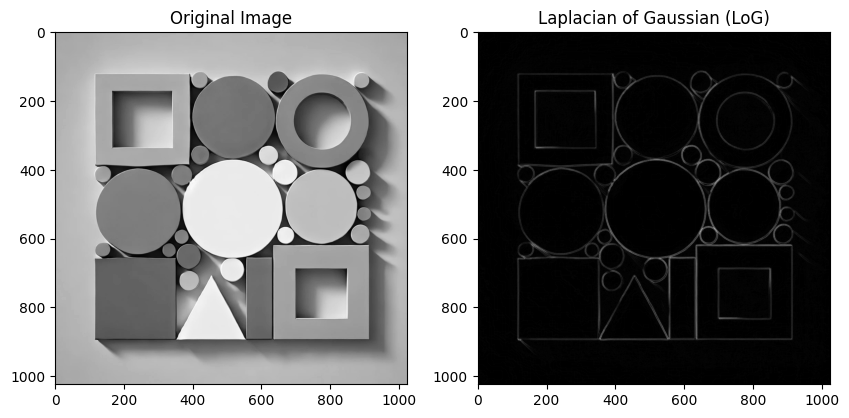

In [77]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img3, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Laplacian of Gaussian (LoG)')
plt.imshow(laplacian_abs, cmap='gray')

plt.show()

# Comparison

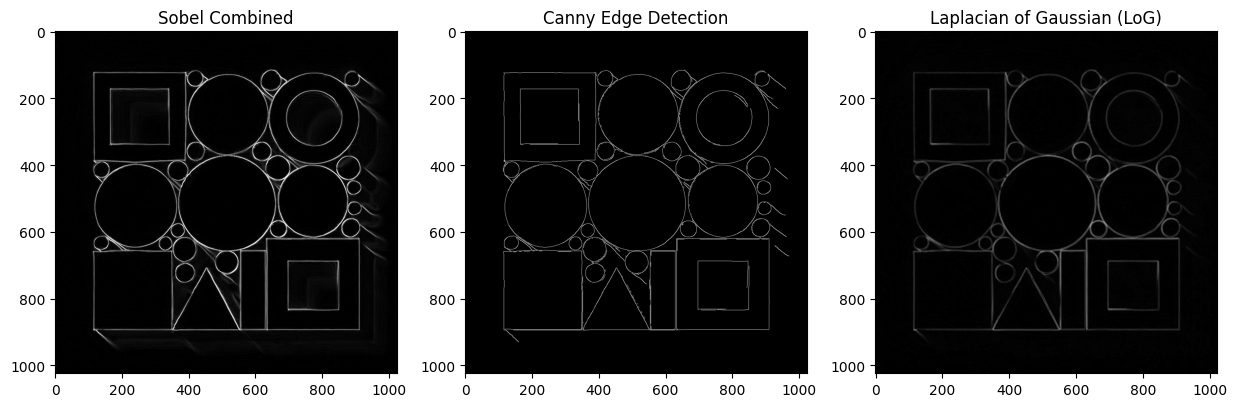

In [78]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Sobel Combined')
plt.imshow(sobel_combined, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Canny Edge Detection')
plt.imshow(edges, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Laplacian of Gaussian (LoG)')
plt.imshow(laplacian_abs, cmap='gray')

plt.show()

## Corner Detection <a class="anchor" id="fifth-bullet"></a>

## Corner detection is used to find points where the edges of an object meet.

### Use-cases: Tracking, object recognition, image stitching.

### Harris Corner Detection Algorithm:
* Gradient Calculation: Compute gradients in the x and y directions.
    * Sobel filters are used to compute the x and y gradients of the image. These gradients are important for detecting changes in intensity, which are used in Harris corner detection.
* Corner Response (Harris Matrix): Use the Harris matrix to calculate the corner response.
    * The Harris matrix (second-moment matrix) is computed for each pixel using the gradients. This matrix is then used to calculate the corner response at each pixel, which indicates how likely a pixel is to be a corner. It is computed over a small window around that pixel.
    * Formula: $$ M = \sum_{u,v} w(u,v) \begin{bmatrix}
I_x(u,v)^2 & I_x(u,v)I_y(u,v) \\
I_x(u,v)I_y(u,v) & I_y(u,v)^2
\end{bmatrix} $$
    * In this context, $ I_x(u,v) $ and $ I_y(u,v) $ represent the partial derivatives of the image intensity \( I(u,v) \) at pixel location \( (u, v) \) in the **x** and **y** directions, respectively. These are the **image gradients** and are used to measure how the intensity of the image changes at that point.
    * The matrix 𝑀 encodes information about how the intensity changes within the window. Specifically, the eigenvalues of this matrix 𝜆1 and 𝜆2 provide insight into the intensity variation:
        * λ1 represents the rate of intensity change in one direction.
        * λ2 represents the rate of intensity change in the orthogonal direction.
        * Flat region (non-edge): Both 𝜆1 and 𝜆2 are small.
        * Edge: One eigenvalue is large and the other is small
        * Corner: Both eigenvalues are large, indicating significant intensity change in both directions.
* Corner Strength (Response Map): Visualize the corner response strength, which indicates potential corners.
    * The response map visualizes the strength of the corners. Pixels with high corner responses correspond to regions where the intensity changes significantly in multiple directions (i.e., corners).
* Thresholding: Highlight strong corners based on the threshold.

The corner response $ R $ is computed as:

$$
R = \text{det}(M) - k \cdot (\text{trace}(M))^2
$$

Where:
- $ M $ is the Harris matrix.
- $ \text{det}(M) = \lambda_1 \lambda_2 = I_x^2 I_y^2 - (I_x I_y)^2 $ is the determinant of the matrix $ M $. 
- $ \text{trace}(M) = \lambda_1 + \lambda_2 = I_x^2 + I_y^2 $ is the trace of the matrix $ M $, which is the sum of the diagonal elements.
- $ k $ is an empirical constant (usually between 0.04 and 0.06).

The response $ R $ is used to classify image points as corners, edges, or flat regions.
- If 𝑅 > 0 The region is a corner (both eigenvalues are large).
- If 𝑅 < 0 The region is an edge (one eigenvalue is large, the other is small).
- If 𝑅 ≈ 0 The region is flat (both eigenvalues are small).

Outputs:
* Original Image: The unmodified image.
* Gradient X and Gradient Y: Visualizes the gradient in the x and y directions, highlighting areas with sharp changes in intensity (edges).
* Harris Corner Response: A heatmap showing the strength of corners at each pixel.
* Thresholded Corners: The binary map where corners above the threshold are highlighted.
* Final Detected Corners: The original image with detected corners marked in red.

In [91]:
img4 = read_img_rgb('../L1/geometric_shapes_2.webp')
gray_img4 = cv2.cvtColor(img4, cv2.COLOR_RGB2GRAY)

In [92]:
# Step 1: Compute Gradient in X and Y directions (Sobel)
grad_x = cv2.Sobel(gray_img4, cv2.CV_64F, 1, 0, ksize=3)
grad_y = cv2.Sobel(gray_img4, cv2.CV_64F, 0, 1, ksize=3)

In [93]:
# Step 2: Compute Harris corner response using OpenCV's built-in function
# Corner detection parameters
corner_response = cv2.cornerHarris(gray_img4, 2, 3, 0.04)

In [94]:
# Step 3: Normalize the corner response for visualization
corner_response_norm = cv2.normalize(corner_response, None, 0, 255, cv2.NORM_MINMAX)

In [95]:

# Step 4: Threshold the response map to highlight strong corners
# Threshold to identify corners
threshold = 0.01 * corner_response.max()
corners_thresholded = np.zeros_like(corner_response)
corners_thresholded[corner_response > threshold] = 255

In [99]:

# Step 5: Mark detected corners on the original image
corners_img = np.copy(img4)

# Make the corners significantly larger by drawing large circles
for y in range(corner_response.shape[0]):
    for x in range(corner_response.shape[1]):
        if corner_response[y, x] > threshold:
            cv2.circle(corners_img, (x, y), 10, (0, 0, 255), 2)  # Large red circles


# corners_img[corner_response > threshold] = [0, 0, 255]  # Mark corners in red

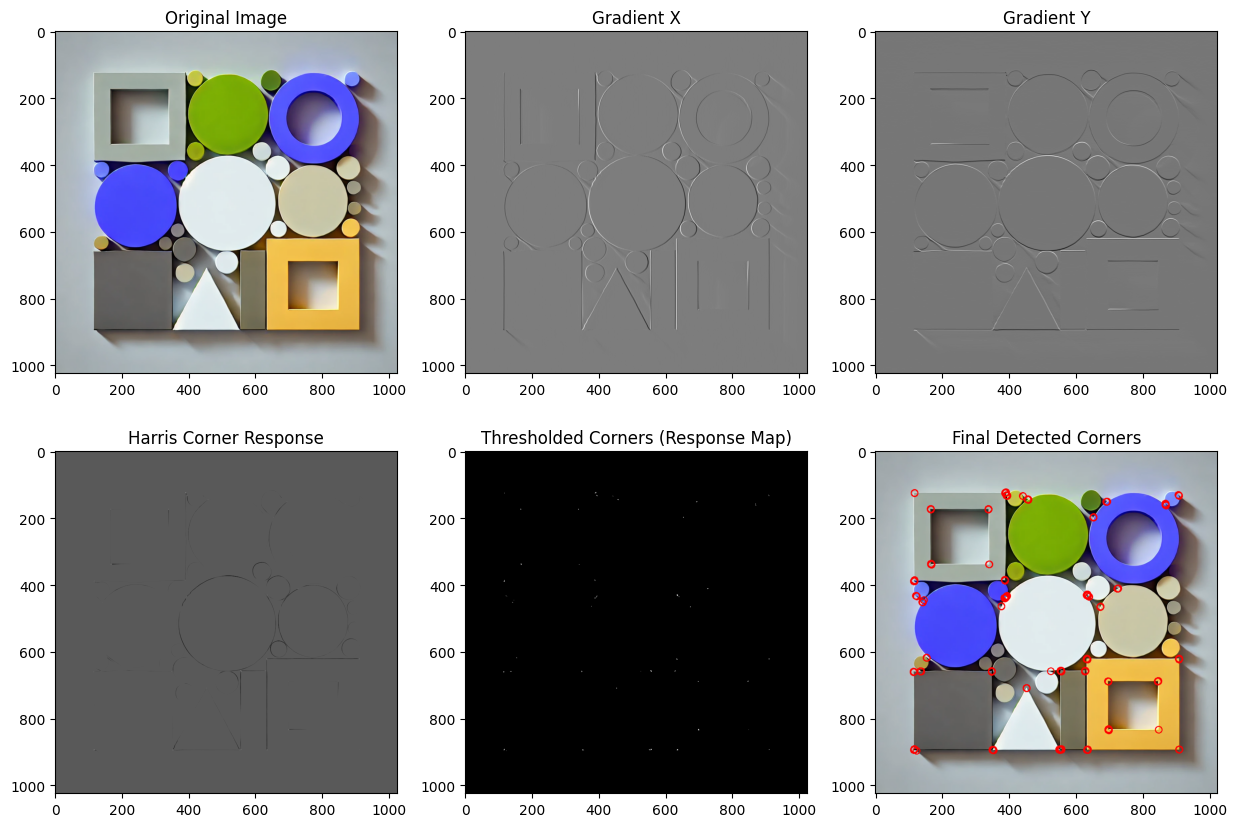

In [100]:
plt.figure(figsize=(15, 10))

# Original Image
plt.subplot(2, 3, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))

# Gradient X
plt.subplot(2, 3, 2)
plt.title('Gradient X')
plt.imshow(grad_x, cmap='gray')

# Gradient Y
plt.subplot(2, 3, 3)
plt.title('Gradient Y')
plt.imshow(grad_y, cmap='gray')

# Harris Response Map
plt.subplot(2, 3, 4)
plt.title('Harris Corner Response')
plt.imshow(corner_response_norm, cmap='gray')

# Thresholded Corner Map
plt.subplot(2, 3, 5)
plt.title('Thresholded Corners (Response Map)')
plt.imshow(corners_thresholded, cmap='gray')

# Final Image with Corners Marked
plt.subplot(2, 3, 6)
plt.title('Final Detected Corners')
plt.imshow(cv2.cvtColor(corners_img, cv2.COLOR_BGR2RGB))

## TLDR <a class="anchor" id="last-bullet"></a>